In [1]:
%reset
%load_ext dotenv
%dotenv

%load_ext autoreload
%autoreload 

Nothing done.


In [5]:
from utils.mongo_utils import db_distance_info_sanitized
import haversine as hs
import numpy as np


df = db_distance_info_sanitized()
# X = df.loc[:, ~df.columns.isin(['_id', 'distance_time'])]
X_geo = df[['origin.lat','origin.lon']]
Y_geo = df['distance_time']
# generate distance from target
# sX['distance_km'] = list(map(hs.haversine, zip(X["origin.lat"], X["origin.lon"]), zip(X["target.lat"], X["target.lon"])))



In [34]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
gaussian_process.fit(X_geo, Y_geo)

lon = np.linspace(17.8,18.2,20)
lat = np.linspace(59.4,59.2,20)
space = [[a,b,hs.haversine((a,b),(18.0591,59.330767))] for a in lon for b in lat]
from scraper import plot

import pandas as pd
tlon = np.full(400,18.0591)
tlat = np.full(400,59.330767)

pred = gaussian_process.predict(pd.DataFrame({'origin.lon':[item[0] for item in space],'origin.lat':[item[1] for item in space]}))

df = pd.DataFrame({'origin.lon':[item[0] for item in space],'origin.lat':[item[1] for item in space],'distance_time':pred})

plot.distance_region(df.values)

/usr/local/Caskroom/miniconda/base/envs/DataScience/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning:

The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.




array([[26.76405235, 25.40015721],
       [25.97873798, 27.2408932 ],
       [26.86755799, 24.02272212],
       ...,
       [-3.32126484, -0.81869834],
       [-6.93197957, -1.90122961],
       [-1.47464656, -1.07108841]])

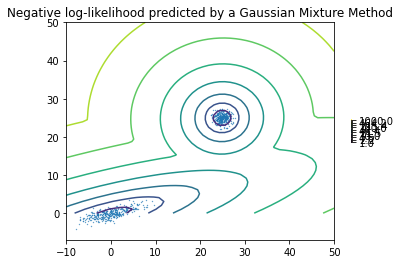

In [27]:
import numpy as np
import matplotlib.pyplot as plot
from matplotlib.colors import LogNorm
from sklearn import mixture

n_samples = 350


np.random.seed(0)


shiftedgaussian = np.random.randn(n_samples, 2) + np.array([25, 25])


c = np.array([[0.0, -0.9], [3.5, 0.9]])
stretchedgaussian = np.dot(np.random.randn(n_samples, 2), c)


X_train = np.vstack([shiftedgaussian, stretchedgaussian])
display(X_train)

classifier = mixture.GaussianMixture(n_components=2, covariance_type="full")
classifier.fit(X_train)


x = np.linspace(-25.0, 35.0)
y = np.linspace(-25.0, 45.0)
x = np.linspace(-10,50)
y = np.linspace(0,50)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -classifier.score_samples(XX)
Z = Z.reshape(X.shape)

cs = plot.contour(
    X, Y, Z, norm=LogNorm(vmin=2.0, vmax=1000.0), levels=np.logspace(0, 3, 10)
)
cb = plot.colorbar(cs, shrink=0.10, extend="both")
plot.scatter(X_train[:, 0], X_train[:, 1], 0.10)

plot.title("Negative log-likelihood predicted by a Gaussian Mixture Method")
plot.axis("tight")
plot.show()

In [31]:
X_geo.values

array([[59.33560755, 18.03537823],
       [59.2736459 , 17.8959877 ],
       [59.33995417, 18.08032747],
       ...,
       [59.3692127 , 17.957616  ],
       [59.363752  , 17.9634453 ],
       [59.3618883 , 17.9767488 ]])

/usr/local/Caskroom/miniconda/base/envs/DataScience/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning:

The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.

/usr/local/Caskroom/miniconda/base/envs/DataScience/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning:

The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.

/usr/local/Caskroom/miniconda/base/envs/DataScience/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning:

The optimal value found for dimension 1 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.



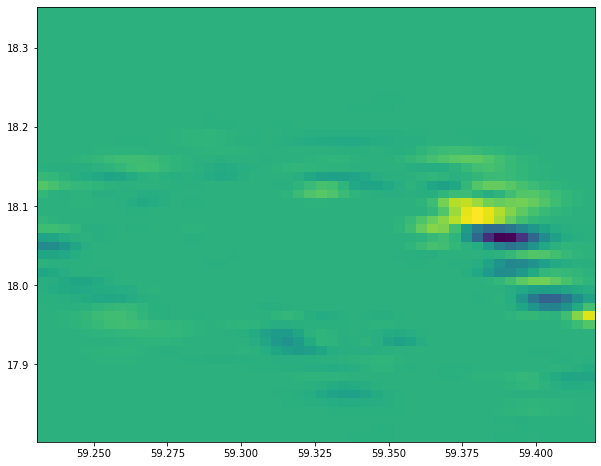

In [31]:


from itertools import product
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

X = np.array([[0,0],[2,0],[4,0],[6,0],[8,0],[10,0],[12,0],[14,0],[16,0],[0,2],
                    [2,2],[4,2],[6,2],[8,2],[10,2],[12,2],[14,2],[16,2]])

y = np.array([-54,-60,-62,-64,-66,-68,-70,-72,-74,-60,-62,-64,-66,
                    -68,-70,-72,-74,-76])

X = X_geo.values
y = Y_geo.values

# Input space
x1 = np.linspace(X[:,0].min(), X[:,0].max()) #p
x2 = np.linspace(X[:,1].min(), X[:,1].max()) #q
x = (np.array([x1, x2])).T

kernel = C(1.0, (1e-3, 1e3)) * RBF([5,5], (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=15)

gp.fit(X, y)

x1x2 = np.array(list(product(x1, x2)))
x2x1 = np.array(list(product(x2, x1)))
y_pred, MSE = gp.predict(x1x2, return_std=True)

X0p, X1p = x1x2[:,0].reshape(50,50), x1x2[:,1].reshape(50,50)
Zp = np.reshape(y_pred,(50,50))

# alternative way to generate equivalent X0p, X1p, Zp
# X0p, X1p = np.meshgrid(x1, x2)
# Zp = [gp.predict([(X0p[i, j], X1p[i, j]) for i in range(X0p.shape[0])]) for j in range(X0p.shape[1])]
# Zp = np.array(Zp).T

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
ax.pcolormesh(X0p, X1p, Zp)

plt.show()


In [93]:
from scraper.plot import distance_region
from itertools import product
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel
from sklearn.gaussian_process import GaussianProcessRegressor
from plotly.subplots import make_subplots

X = X_geo.values
y = Y_geo.values

# Input space
x1 = np.linspace(X[:,1].min(), X[:,1].max()) 
x2 = np.linspace(X[:,0].min(), X[:,0].max())

x1 = np.linspace(17.95, 18.14)
x2 = np.linspace(59.28, 59.38)

# kernel =  ConstantKernel(1.0) + ConstantKernel(1.0) * RBF(10)  + WhiteKernel(5)

kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF([5,5], (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=15)
gp.fit(X, y)

x2x1 = np.array(list(product(x2, x1)))
y_pred, MSE = gp.predict(x2x1, return_std=True)

new_data = np.column_stack((x2x1,y_pred))

fig = distance_region(new_data) 
fig.update_layout(height=600, width=800, title_text="Prediction",margin={"r":0,"t":0,"l":0,"b":0})
fig.show()




/usr/local/Caskroom/miniconda/base/envs/DataScience/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning:

The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.

/usr/local/Caskroom/miniconda/base/envs/DataScience/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning:

The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.

/usr/local/Caskroom/miniconda/base/envs/DataScience/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning:

The optimal value found for dimension 1 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.



In [87]:
import plotly.graph_objects as go

input_data = df[['origin.lat', 'origin.lon', 'distance_time']]


fig = go.Figure()
fig.add_trace(go.Contour(
        z=y_pred,
        x=x1, # horizontal axis
        y=x2, # vertical axis
        zmin = 0,
        zmax = 4000,
        opacity=0.6
        # contours_coloring='lines',
    ))
fig.add_trace(
    go.Scatter(
     x=input_data.iloc[:,1].values, y=input_data.iloc[:,0].values,
     mode = 'markers',
     text=input_data.iloc[:,2].values,
     marker = dict(
            color=input_data.iloc[:,2].values,
            size = 3,
            cmax = 4000,
            cmin = 0,
            colorscale=["Lime","gold","orangered"],

        )
    ))
fig.update_layout(height=600, width=800, title_text="Prediction",margin={"r":0,"t":0,"l":0,"b":0})
fig.show()